# Predicción del COVID-19 en Argentina usando un modelo logístico

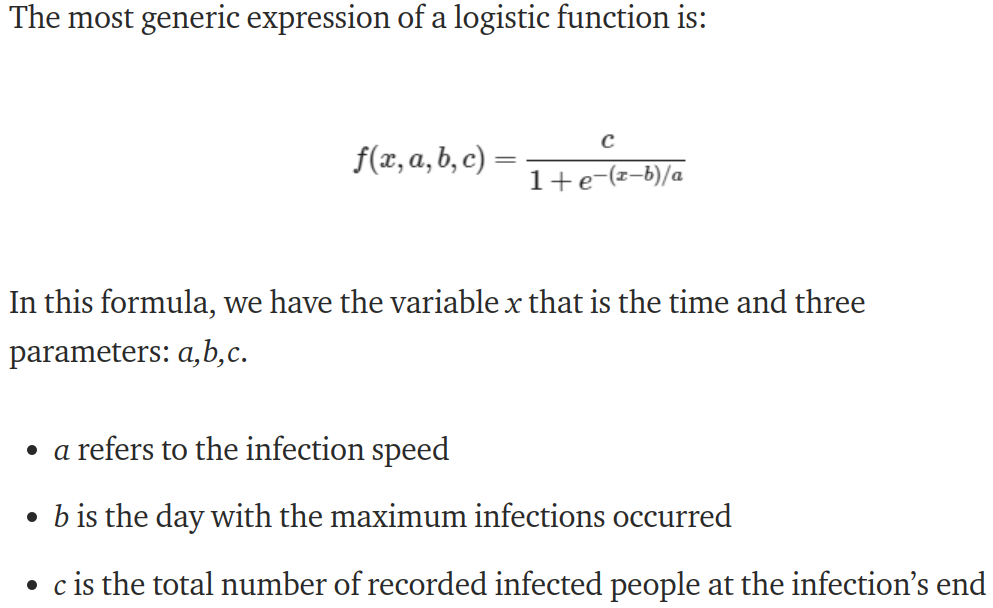

In [1]:
from IPython.display import Image
Image("img/logistic-method.png")

### Se importan las librerías 

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

### Se lee el Dataset

In [3]:
df = pd.read_csv("covid19-argentina.csv")

df

,day,infected
0,2020-03-05 18:00:00,1
1,2020-03-06 18:00:00,3
2,2020-03-07 18:00:00,7
3,2020-03-08 18:00:00,12
4,2020-03-09 18:00:00,17
5,2020-03-10 18:00:00,19
6,2020-03-11 17:00:00,21
7,2020-03-12 17:00:00,31
8,2020-03-13 17:00:00,34
9,2020-03-14 17:00:00,45


### Se preparan los datos

In [4]:
df = df.loc[:,['day','infected']]
FMT = '%Y-%m-%d %H:%M:%S'
date = df['day']
df['day'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)

df

,day,infected
0,64,1
1,65,3
2,66,7
3,67,12
4,68,17
5,69,19
6,70,21
7,71,31
8,72,34
9,73,45


### Factor de crecimiento

El factor de crecimiento sirve para saber cuánto creció el numero de infectados en relación con el día anterior (Nd/Nd-1)

In [5]:
#dataframeGrowthFactor
dfGF = df.copy()
dfGF['new_infected'] = dfGF.diff()['infected']
dfGF['cases_growth_%'] = round(dfGF['new_infected'] / (dfGF['infected'] - dfGF['new_infected']) * 100, 1)
dfGF

,day,infected,new_infected,cases_growth_%
0,64,1,NaN,NaN
1,65,3,2.0,200.0
2,66,7,4.0,133.3
3,67,12,5.0,71.4
4,68,17,5.0,41.7
5,69,19,2.0,11.8
6,70,21,2.0,10.5
7,71,31,10.0,47.6
8,72,34,3.0,9.7
9,73,45,11.0,32.4


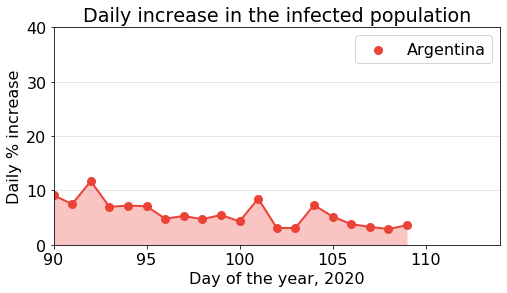

In [6]:
dfg2 = dfGF[-20:]
x = dfg2['day'].tolist()
y = dfg2['cases_growth_%'].tolist()

import matplotlib.pyplot as plt
plt.rc('font', size=16)
plt.figure(figsize=(8, 4))
plt_axes = plt.gca()
plt_axes.grid(axis='y', color=(0.4, 0.4, 0.4), alpha=0.2)
plt.stackplot(x, y, color=(0.92, 0.26, 0.21, 0.3), linewidth=0)
plt.plot(x, y, color=(0.92, 0.26, 0.21), linewidth=2)
plt.scatter(x, y, color=(0.92, 0.26, 0.21), label="Argentina", linewidth=3)
plt.xlim(int(min(x)), int(max(x) + 5))
plt.ylim(0, 40)
plt.title("Daily increase in the infected population")
plt.xlabel("Day of the year, 2020")
plt.ylabel("Daily % increase")
plt.legend()
plt.show()

### Se define la función

In [7]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

### Función genérica

In [8]:
def fit_logistic_method(df):
    cant = df.shape[0]
    x = list(df.iloc[:,0])
    y = list(df.iloc[:,1])
    lastDay = df['day'][df.index[-1]]
    
    initial_parameters = 2.5, lastDay, 250000   #velocidad de contagio
                                            #día con el máximo valor de infectados. Por ahora es el último día
                                            #amplitud máxima esperada (sacada de los valores oficiales)

    #curve_fit estima los valores y errores de la función
    fit = curve_fit(logistic_model,x,y,p0=initial_parameters, maxfev=10000) #maxfev se incrementa a 10000 para prevenir errores en el entrenamiento de la curva
    #errores
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    #parámetros
    a = fit[0][0]
    b = fit[0][1]
    c = fit[0][2]
    #solución - día final
    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c)*0.9999,b))
    
    return a, b, c, errors, sol, x, y, cant
    

In [9]:
def prediction(df):
    speedInfections, peakDay, maxAmplitude, errors, endDay, days, infections, cantSamples = fit_logistic_method(df)
    speedError = errors[0]
    peakDayError = errors[1]
    maxAmplitudeError = errors[2]
    
    print("Total infected: " + str(int(round(maxAmplitude))) +
          " (± " + str(int(round(maxAmplitudeError))) + ")")
    print("Peak´s day: " + str(datetime(2020, 1, 2) + 
        timedelta(days=int(round(peakDay)))) + 
        " (± " + str(round(peakDayError, 2)) + ")")
    print("End´s day: " + str(datetime(2020, 1, 2) + timedelta(days=endDay)))


### Funciones para el Plot

In [10]:
plt.rc('font', size=14)

def add_real_data(df, label, color=None):
    x = df['day'].tolist()
    y = df['infected'].tolist()
    plt.scatter(x, y, label="Data (" + label + ")", c=color)

def add_logistic_curve(df, label, **kwargs):
    speedInfections, peakDay, maxAmplitude, _, endDay, days, infections, _ = fit_logistic_method(df)
    dayRange = list(range(min(days), endDay))

    plt.plot(dayRange,
             [logistic_model(i, speedInfections, peakDay, maxAmplitude) for i in dayRange],
             label="Logistic model (" + label + "): " + str(int(round(maxAmplitude))),
             **kwargs)
    return maxAmplitude

def label_and_show_plot(plt, title, maxAmplitude=None):
    plt.title(title)
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    if (maxAmplitude):
        plt.ylim(0, maxAmplitude * 1.1)
    plt.legend()
    plt.show()

### Predicciones de dos días atras

In [11]:
prediction(df[:-2])

Total infected: 3037 (± 93)
Peak´s day: 2020-04-06 00:00:00 (± 0.52)
End´s day: 2020-05-26 00:00:00


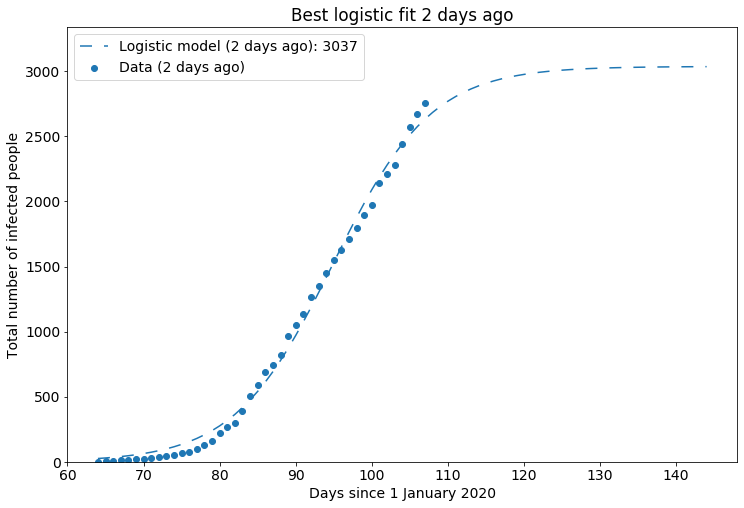

In [12]:
# Plot
plt.figure(figsize=(12, 8))
add_real_data(df[:-2], "2 days ago")
maxAmplitude = add_logistic_curve(df[:-2], "2 days ago", dashes=[8, 8])
label_and_show_plot(plt, "Best logistic fit 2 days ago", maxAmplitude)

### Predicciones de un día atras

In [13]:
prediction(df[:-1])

Total infected: 3138 (± 93)
Peak´s day: 2020-04-06 00:00:00 (± 0.52)
End´s day: 2020-05-30 00:00:00


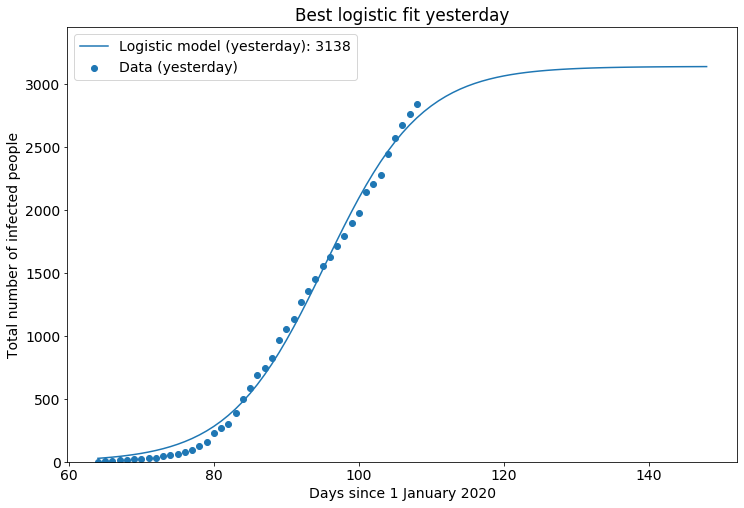

In [14]:
# Plot
plt.figure(figsize=(12, 8))
add_real_data(df[:-1], "yesterday")
maxAmplitude = add_logistic_curve(df[:-1], "yesterday")
label_and_show_plot(plt, "Best logistic fit yesterday", maxAmplitude)

### Predicciones de hoy

In [15]:
prediction(df)

Total infected: 3238 (± 93)
Peak´s day: 2020-04-07 00:00:00 (± 0.52)
End´s day: 2020-05-30 00:00:00


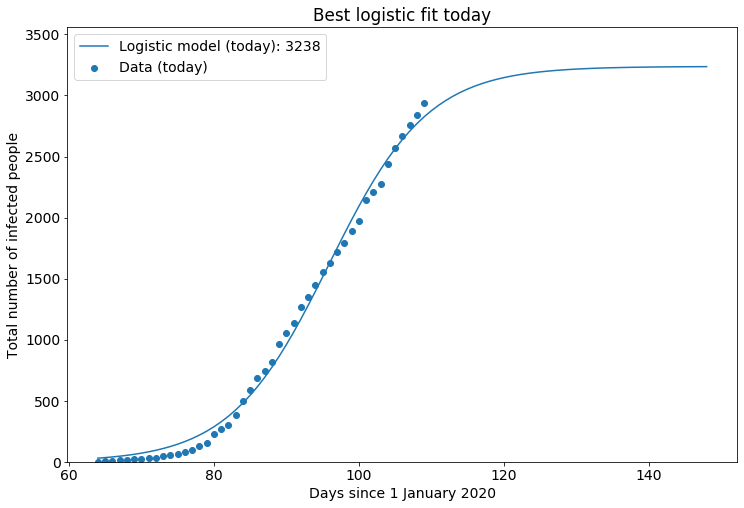

In [16]:
# Plot
plt.figure(figsize=(12, 8))
add_real_data(df, "today")
maxAmplitude = add_logistic_curve(df, "today")
label_and_show_plot(plt, "Best logistic fit today", maxAmplitude)

### Todos juntos

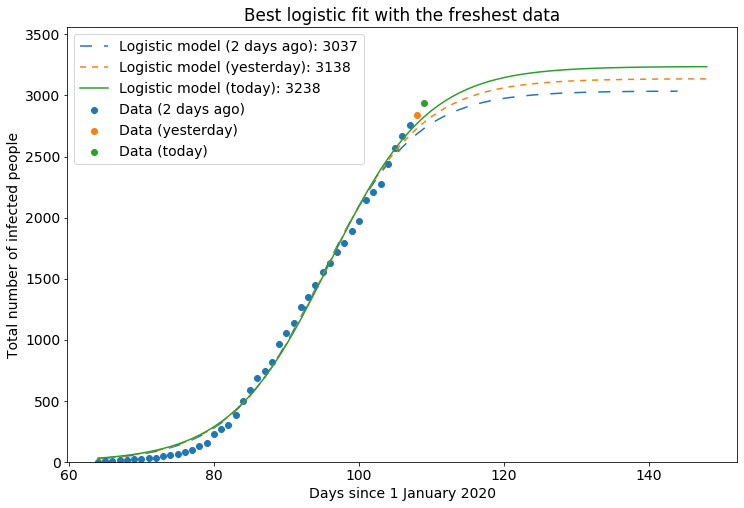

In [17]:
# Plot
plt.figure(figsize=(12, 8))
add_real_data(df[:-2], "2 days ago")
add_real_data(df[-2:-1], "yesterday")
add_real_data(df[-1:], "today")
add_logistic_curve(df[:-2], "2 days ago", dashes=[8, 8])
add_logistic_curve(df[:-1], "yesterday", dashes=[4, 4])
maxAmplitude = add_logistic_curve(df, "today")
label_and_show_plot(plt, "Best logistic fit with the freshest data", maxAmplitude)

### Cambios en las predicciones desde hace 2 días hasta hoy

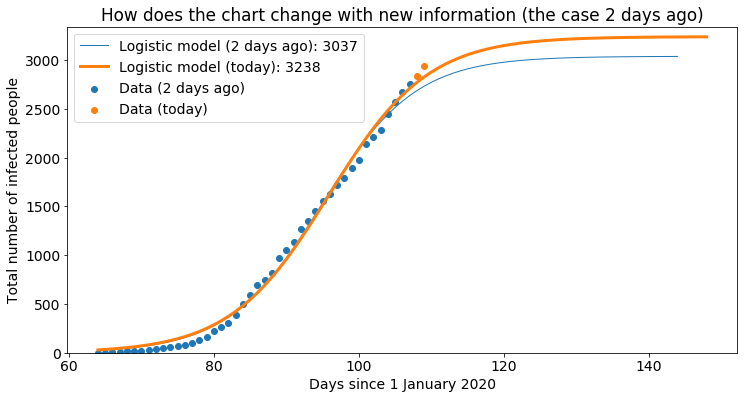

In [18]:
plt.figure(figsize=(12, 6))
add_real_data(df[:-2], "2 days ago")
add_real_data(df[-2:], "today")
maxAmplitude = add_logistic_curve(df[:-2], "2 days ago", linewidth=1)
add_logistic_curve(df, "today", linewidth=3)
label_and_show_plot(plt, "How does the chart change with new information (the case 2 days ago)", maxAmplitude)

## Experiment 1: Delete noisy data

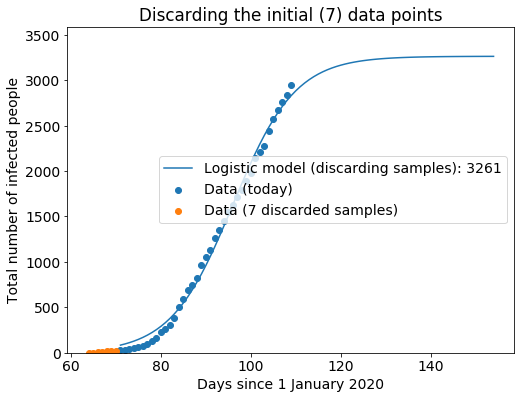

Total infected: 3261 (± 104)
Peak´s day: 2020-04-07 00:00:00 (± 0.58)
End´s day: 2020-06-05 00:00:00


In [19]:
#dataframeGrowthFactor
#dfN = df.copy()
dfN = df.copy()
#dfN = sum50(df[22:])
#@title Try it yourself { run: "auto", vertical-output: true, form-width: "620px", display-mode: "form" }
points_to_discard = 7 #@param {type:"slider", min:0, max:15, step:1}

# Plot: discard initial data points
plt.figure(figsize=(8, 6))
pts = points_to_discard
add_real_data(dfN[pts:], "today")
add_real_data(dfN[:pts], str(pts) + " discarded samples")
y_max = add_logistic_curve(dfN[pts:], "discarding samples")
label_and_show_plot(plt, "Discarding the initial (" + str(pts) + ") data points", y_max)
prediction(dfN[pts:])

## Experiment 2: Lineal Regression

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

In [21]:
points_to_discard = 19
pts = points_to_discard

In [22]:
data = df.copy()
data.drop(data.columns[[1]], axis=1, inplace=True)
data.mask(np.isinf(data), inplace=True)
data.dropna(inplace=True)

In [23]:
target = df.copy()
target.drop(target.columns[[0]], axis=1, inplace=True)
target.mask(np.isinf(target), inplace=True)
target.dropna(inplace=True)

In [24]:
#pearsonr(data[pts:], target[pts:])[0][0]

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(data[pts:], target[pts:], test_size=0.2)

In [26]:
modelo = LinearRegression()
modelo.fit(X_train, Y_train)
modelo.score(X_test, Y_test)

0.9972199446648196

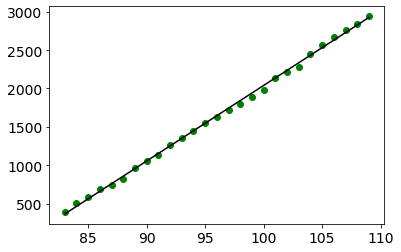

In [27]:
plt.scatter(data[pts:], target[pts:], color='g')
plt.plot(data[pts:], modelo.predict(data[pts:]), color='k')
plt.show()

In [28]:
modelo.coef_

array([[98.50790922]])

In [29]:
modelo.intercept_

array([-7811.90440165])

In [30]:
lastDay = df['day'][df.index[-1]]
tomorrow = lastDay +1
modelo.predict([[tomorrow]])

array([[3023.9656121]])

In [31]:
oneWeek = tomorrow + 7
modelo.predict([[oneWeek]])

array([[3713.52097662]])